# min $\Delta$R region opt

In [2]:
from plots import draw_SR, draw_VR, draw_CR

import os
os.sys.path+= ['../RRevolution/code/','../code/']
from analysis import getXhh
from utils import mcToYr
from eventDisplays import rainbow_text

import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot

import matplotlib.pyplot as plt
from matplotlib import gridspec

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [3]:
uproot.__version__

'4.0.4'

In [4]:
bcols = ['m_h1','m_h2','m_hh','ntag','kinematic_region']

In [40]:
yr = 17

fname = f'../data/RR/nom_trigs_unblind/data{yr}_min_dR_VEC_sr_124_117.root'
text = "$\mathbf{ATLAS}$ "+f"data 20{yr} Internal\n"
figDir = f'figures/min_dR_sr_opt_{yr}'


# With the  X_wt cut
# tname = 'fullmassplane'
# cut_str = '~ pass_vbf_sel'

# text += r"min_dR, $X_{wt}$ > 1.5, VBF veto"


# Before the X_wt cut
tname='everything'
cut_str = '(dEta_hh < 1.5) & (~ pass_vbf_sel)'

text += r"min_dR, pre-$X_{wt}$, VBF veto"
figDir += '/pre_Xwt'


In [41]:
if not os.path.exists(figDir):
    os.mkdir(figDir)

In [42]:
with uproot.open(f'{fname}:{tname}') as t:
    bdf = t.arrays(bcols+['pass_vbf_sel'],cut_str,library='pd')[bcols]

In [43]:
bdf.head()

m_h1        m_h2         m_hh  ntag  kinematic_region
1   338.054962   57.719505   573.269104     2                 3
2   121.129082  207.788071   503.211914     2                 3
5   109.086014  225.704041   531.984924     2                 3
6   448.122803  148.290710  1453.627197     2                 3
11  172.157227   97.524261   421.718719     2                 3

In [44]:
len(bdf)

19342039

In [45]:
x1, y1 = 124,117

In [46]:
bdf[f'Xhh_{x1}_{y1}'] = getXhh(bdf.m_h1,bdf.m_h2, x1, y1)

In [47]:
def scan_r_eps(df,mask, eps,r, x,y):
    '''
    Scan over the mean (m_h1, m_h2) values as we
    scan over the analysis region definitions.
    
    Inputs:
    - df: Input df (with m_h1 and m_h2 columns)
    - mask: mask to applay to df when considering these means 
            (i.e, b-tagging and SR / VR mask)
    - r: radii to consider
    - eps: Shifts to vary x1, x2 by (i.e)
    - x: m_h1 mean we're trying to match to 
    - y: m_h2 mean we're trying to match to 

    Output:
    - mu_x, mu_y: Arrays w/ shape (len(eps),len(r))
    '''

    mu_x, mu_y = [], []
    
    epsilons, rs = np.meshgrid(eps, r)

    for epsi, ri in tqdm(zip(epsilons.flatten(), rs.flatten())):
        
        reg = np.sqrt((df['m_h1'] - x * (1+epsi))**2 + (df['m_h2'] - y * (1+epsi))**2) < ri
        
        mu_x.append(bdf.loc[reg & mask,'m_h1'].mean())
        mu_y.append(bdf.loc[reg & mask,'m_h2'].mean())
        
    size = rs.shape
    mu_x = np.array(mu_x).reshape(*size)
    mu_y = np.array(mu_y).reshape(*size)
    return mu_x, mu_y

In [48]:
deltas = np.linspace(0,.05,11)
r_VRs  = np.linspace(15,45,7)

In [49]:
mask = (bdf.ntag==2) & (bdf[f'Xhh_{x1}_{y1}'] < 1.6)
x1_2b, y1_2b = bdf.loc[mask,['m_h1','m_h2']].mean().values

args = (deltas,r_VRs, x1, y1)
notSR = (bdf[f'Xhh_{x1}_{y1}'] >= 1.6)

mu_2b_x, mu_2b_y = scan_r_eps(bdf, (bdf.ntag==2) & notSR, *args)
mu_3b_x, mu_3b_y = scan_r_eps(bdf, (bdf.ntag==3) & notSR, *args)
mu_4b_x, mu_4b_y = scan_r_eps(bdf, (bdf.ntag>=4) & notSR, *args)

77it [00:27,  2.79it/s]
77it [00:23,  3.26it/s]
77it [00:23,  3.27it/s]


In [50]:
x1_2b, y1_2b

(125.12254, 118.82018)

min_dR 2b 2017 m_{h1} 7 0.384033203125
min_dR 2b 2017 m_{h2} 5 -0.17510986328125
min_dR 3b 2017 m_{h1} 7 -0.1446075439453125
min_dR 3b 2017 m_{h2} 5 -0.1821746826171875
min_dR 4b 2017 m_{h1} 7 -0.30084991455078125
min_dR 4b 2017 m_{h2} 6 0.058197021484375


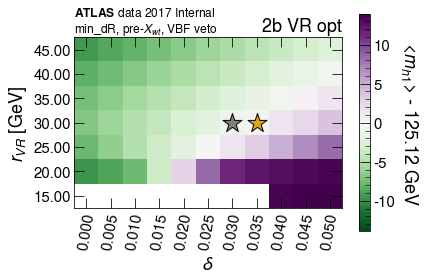

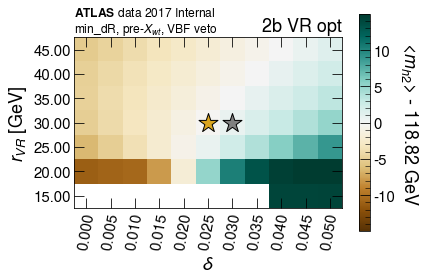

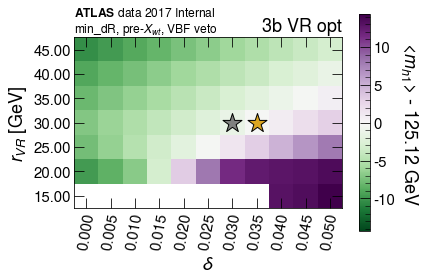

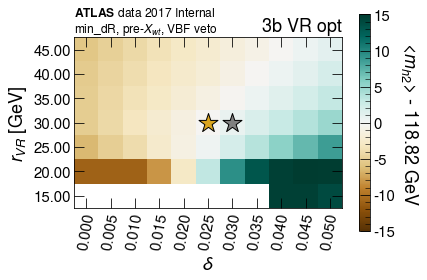

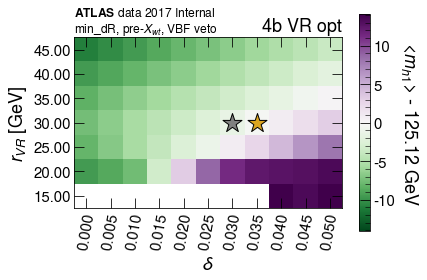

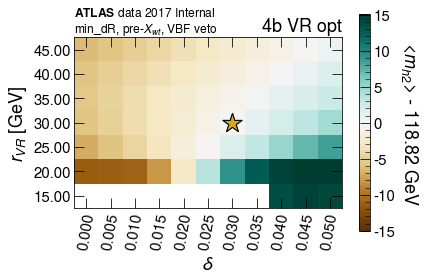

In [51]:
for mu_x,mu_y,ntag in zip([mu_2b_x,mu_3b_x,mu_4b_x], [mu_2b_y,mu_3b_y,mu_4b_y], [2,3,4]):

    for mus, cmap, mean, var in zip([mu_x,mu_y],['PRGn_r','BrBG'],[x1_2b,y1_2b],['$m_{h1}$','$m_{h2}$']):

        z = mus - mean

        v = np.max(np.abs(np.nan_to_num(z)))

        plt.figure()
        plt.imshow(z, cmap=cmap, vmin=-v, vmax=v, origin='lower')
        cbar = plt.colorbar()
        cbar.set_label(f'<{var}> - {mean:.2f} GeV',rotation=270,fontsize=18,labelpad=25)
        
        plt.xticks(range(11),[f'{d:.3f}' for d in deltas],rotation=80)
        plt.yticks(range(7),[f'{r:.2f}' for r in r_VRs])

        ax = plt.gca()
        ax.tick_params(which='minor', length=0)

        plt.xlabel('$\delta$',fontsize=18)
        plt.ylabel('$r_{VR}$ [GeV]', fontsize=18)

        plt.title(f'{ntag}b VR opt',loc='right')

        # Put a star on the plot
        plt.scatter([6],[3],400,color='grey',marker='*',edgecolors='k')

        # And *also* put a gold star on the plot for where the optimal point w/ r_VR = 30 GeV
        j = np.argmin(np.abs(np.where(np.nan_to_num(z[3])==0,np.inf,z[3])))
        plt.scatter([j],[3],400,color='goldenrod',marker='*',edgecolors='k')

        print(f'min_dR {ntag}b 2017',var[1:-1],j,z[3,j])
        
        # text on the upper L corner
        plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)
        plt.savefig(f'{figDir}/m_h{var[-3]}_{ntag}b_scan_delta_r_VR.pdf',bbox_inches='tight')
        
    #break

**Conclusion:** It does seem like $\delta = 0.03$ is still chill for this massplane too.

Also, it's probably easier to digest this plot if I just show the column that keeps the radius constant, and then overlay all of the b-tag curves (or at least 2b and 4b).

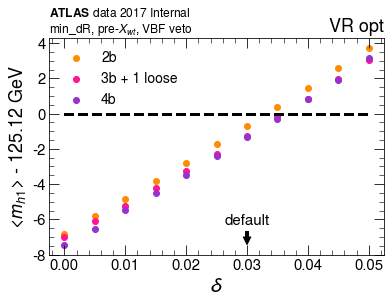

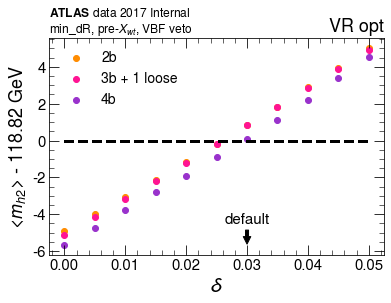

In [52]:
for mus,mean,var in zip([[mu_2b_x,mu_3b_x,mu_4b_x],[mu_2b_y,mu_3b_y,mu_4b_y]],
                        [x1_2b,y1_2b],['$m_{h1}$','$m_{h2}$']):

    plt.figure()
    for mu_i,ntag,c in zip(mus, [2,3,4],['darkorange','deeppink','darkorchid']):

        # J choose the row corresponding to r_VR = 30 GeV
        z = mu_i[3] - mean
        l = '3b + 1 loose' if ntag==3 else f'{ntag}b'
        plt.scatter(deltas,z, color=c,label=l)
            
    plt.plot(deltas,np.zeros_like(deltas),'k--')
    #ax.tick_params('x',which='minor', length=0)

    plt.xlabel('$\delta$',fontsize=20)
    plt.ylabel(f'<{var}> - {mean:.2f} GeV', fontsize=18)

    ymin,ymax = plt.ylim()
    plt.annotate('default',(.03,ymin+.5),(.03,ymin+1.75),
                 arrowprops={'arrowstyle':'simple','color':'k'},
                 ha='center')
    plt.legend(loc='upper left')
    ax = plt.gca()
    plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)
    plt.title('VR opt',loc='right')
    plt.savefig(f'{figDir}/m_h{var[-3]}_r_VR_{r_VRs[3]}GeV.pdf',bbox_inches='tight')
        


In [53]:
r_VR = 30
delta = 0.03

In [54]:
bdf['kr_new'] = 3

bdf.loc[bdf[f'Xhh_{x1}_{y1}'] < 1.6,'kr_new'] = 0

VR = np.sqrt((bdf['m_h1'] - x1 * (1+delta))**2 + (bdf['m_h2'] - y1 * (1+delta))**2) < r_VR
bdf.loc[VR & (bdf.kr_new != 0),'kr_new'] = 1


### Moving on to the CR proposal

In [55]:
epsilons = np.linspace(0,0.08,17)
r_CRs = np.linspace(30,60,7)

In [56]:
epsilons

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 ])

In [57]:
args = (epsilons,r_CRs, x1,y1)
notVR = bdf['kr_new'] > 1

cr_2b_x, cr_2b_y = scan_r_eps(bdf, (bdf.ntag==2) & notVR, *args)
cr_3b_x, cr_3b_y = scan_r_eps(bdf, (bdf.ntag==3) & notVR, *args)
cr_4b_x, cr_4b_y = scan_r_eps(bdf, (bdf.ntag>=4) & notVR, *args)

119it [00:29,  4.00it/s]
119it [00:21,  5.59it/s]
119it [00:21,  5.58it/s]


min_dR 2b 2017 m_{h1} 13 0.443023681640625
min_dR 2b 2017 m_{h2} 8 -0.276031494140625
min_dR 3b 2017 m_{h1} 13 -0.46523284912109375
min_dR 3b 2017 m_{h2} 9 0.37985992431640625
min_dR 4b 2017 m_{h1} 14 -0.34288787841796875
min_dR 4b 2017 m_{h2} 9 -0.2930755615234375


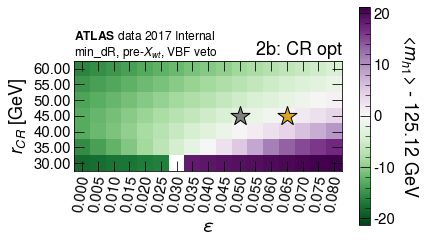

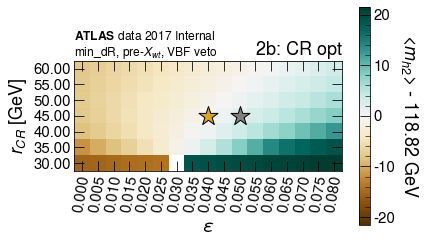

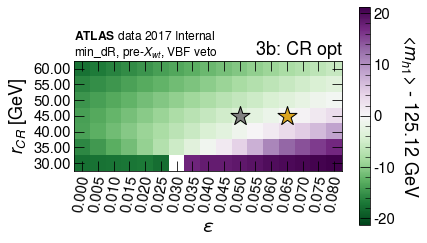

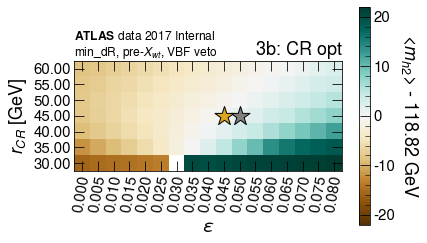

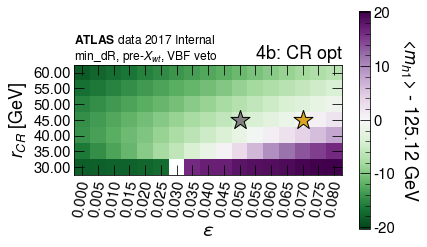

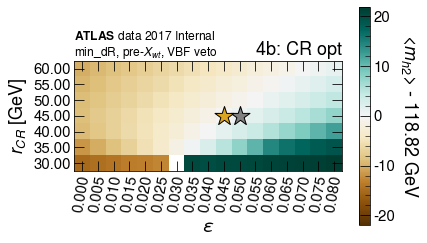

In [58]:
for mu_x,mu_y,ntag in zip([cr_2b_x,cr_3b_x,cr_4b_x], [cr_2b_y,cr_3b_y,cr_4b_y], [2,3,4]):

    for mus, cmap, mean, var in zip([mu_x,mu_y],['PRGn_r','BrBG'],[x1_2b,y1_2b],['$m_{h1}$','$m_{h2}$']):

        z = mus - mean

        v = np.max(np.abs(np.nan_to_num(z)))

        plt.figure()
        plt.imshow(z, cmap=cmap, vmin=-v, vmax=v, origin='lower')
        cbar = plt.colorbar()
        cbar.set_label(f'<{var}> - {mean:.2f} GeV',rotation=270,fontsize=18,labelpad=25)

        plt.xticks(range(len(epsilons)),[f'{d:.3f}' for d in epsilons],rotation=80)
        plt.yticks(range((len(r_CRs))),[f'{r:.2f}' for r in r_CRs])

        ax = plt.gca()
        ax.tick_params(which='minor', length=0)

        plt.xlabel(r'$\varepsilon$',fontsize=18)
        plt.ylabel('$r_{CR}$ [GeV]', fontsize=18)

        plt.title(f'{ntag}b: CR opt',loc='right')

        # Put a star on the plot for the old shift
        plt.scatter([10],[3],400,color='grey',marker='*',edgecolors='k')

        # And *also* put a gold star on the plot for where the optimal point w/ r_VR = 30 GeV
        j = np.argmin(np.abs(np.where(np.nan_to_num(z[3])==0,np.inf,z[3])))
        plt.scatter([j],[3],400,color='goldenrod',marker='*',edgecolors='k')

        print(f'min_dR {ntag}b 2017',var[1:-1],j,z[3,j])

        plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)
        plt.savefig(f'{figDir}/m_h{var[-3]}_{ntag}b_scan_epsilon_r_CR_delta_{delta}.pdf',bbox_inches='tight')


It appears that the CR really *does* want to be asymmetric lol.

But again, I think this is going to be easier to visualize with the1d distributions!!

In [59]:
len(z),len(epsilons)

(7, 17)

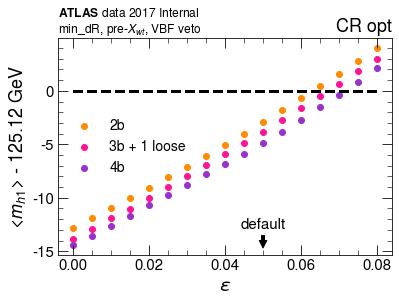

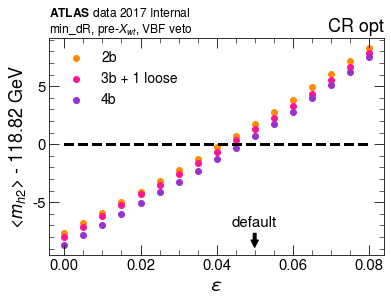

In [60]:
for mus,mean,var,loc in zip([[cr_2b_x,cr_3b_x,cr_4b_x],[cr_2b_y,cr_3b_y,cr_4b_y]],
                            [x1_2b,y1_2b],['$m_{h1}$','$m_{h2}$'],
                            ['center left','upper left']):

    plt.figure()
    for mu_i,ntag,c in zip(mus, [2,3,4],['darkorange','deeppink','darkorchid']):

        # J choose the row corresponding to r_CR = 45 GeV
        z = mu_i[3] - mean
        l = '3b + 1 loose' if ntag==3 else f'{ntag}b'
        plt.scatter(epsilons, z, color=c,label=l)
            
    plt.plot(epsilons,np.zeros_like(epsilons),'k--')

    plt.xlabel(r'$\varepsilon$',fontsize=18)
    plt.ylabel(f'<{var}> - {mean:.2f} GeV', fontsize=18)

    ymin,ymax = plt.ylim()
    plt.annotate('default',(.05,ymin+.5),(.05,ymin+2.5),
                 arrowprops={'arrowstyle':'simple','color':'k'},
                 ha='center')
    plt.legend(loc=loc)
    ax = plt.gca()
    plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)
    plt.title('CR opt',loc='right')
    
    plt.savefig(f'{figDir}/m_h{var[-3]}_r_CR_{r_CRs[3]}GeV_delta_{delta}.pdf',bbox_inches='tight')

In [61]:
epsilons[7]

0.035

**Proposal:** $\varepsilon_1$ = .06 and  $\varepsilon_2$ = .035

In [62]:
r_CR = 45

epsilon1 = .06
epsilon2 = .035

CR = np.sqrt((bdf['m_h1'] - x1 * (1+epsilon1))**2 + (bdf['m_h2'] - y1 * (1+epsilon2))**2) < r_CR
bdf.loc[CR & (bdf.kr_new > 1),'kr_new'] = 2

**Plot the aggregation metrics**

We also want to put the *old* baseline on these plotts

In [63]:
x0,y0 = 120,110
d0, e0 = 0.03, 0.05

bdf[f'Xhh_{x0}_{y0}'] = getXhh(bdf.m_h1,bdf.m_h2, x0, y0)

bdf['kr_old'] = 3
bdf.loc[bdf[f'Xhh_{x0}_{y0}']<1.6,'kr_old'] = 0

VR = np.sqrt((bdf['m_h1'] - x0 * (1+d0))**2 + (bdf['m_h2'] - y0 * (1+d0))**2) < r_VR
bdf.loc[VR & (bdf.kr_old != 0),'kr_old'] = 1

CR = np.sqrt((bdf['m_h1'] - x0 * (1+e0))**2 + (bdf['m_h2'] - y0 * (1+e0))**2) < r_CR
bdf.loc[CR & (bdf.kr_old > 1),'kr_old'] = 2

In [64]:
np.sum(bdf.kinematic_region==0),np.sum(bdf.kr_new==0)

(407825, 407825)

In [65]:
np.sum(bdf.kinematic_region==1),np.sum(bdf.kr_new==1)

(516380, 516381)

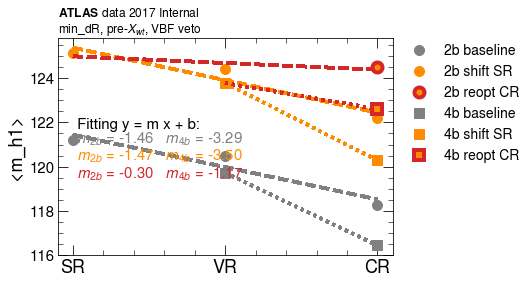

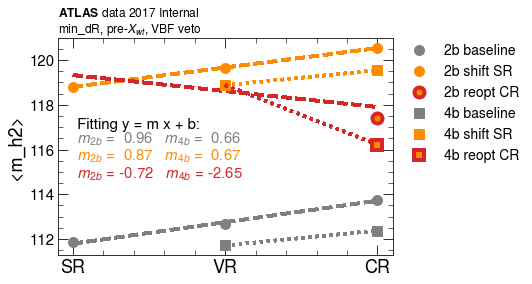

In [66]:
for col in ['m_h1','m_h2']:

    
    lt = ['Fitting y = m x + b:','','',''] 
    lc = ['k','grey','darkorange','C3']
    
    plt.figure()
      
    for ntag,mask,marker,ls in zip([2,4],[bdf.ntag==2,bdf.ntag>=4],['o','s'],['--','dotted']):

        # Old analysis regions
        for k,c,l,i in zip(['kr_old','kinematic_region','kr_new'],lc[1:],
                           ['baseline','shift SR','reopt CR'],range(3)):
            
            vs = [np.mean(bdf.loc[mask & (bdf[k] == i),col]) for i in range(3)]
            
            if ntag==2:
                xi = np.arange(3)
                vi = np.array(vs)
                                    
            else:
                xi = np.arange(1,3)
                vi = np.array(vs[1:])
                
            # best fit line
            m,b = np.polyfit(xi,vi,1)
            plt.plot(xi,xi*m+b,c,ls=ls)

            t = '$m_{' + f'{ntag}b' + '}$ = '+f'{m: .2f}   '
            lt[i+1] += t
                
            if k == 'kr_new':
                # J plot the CR
                plt.plot([2],vs[-1],marker=marker,color='darkorange',markersize=10,
                markeredgecolor=c,markeredgewidth=4,lw=0,label=f'{ntag}b {l}')

            else:
                plt.plot(xi,vi,marker=marker,color=c,markersize=10,lw=0,label=f'{ntag}b {l}')
            
                
    ax = plt.gca()
    plt.xticks(range(3),['SR','VR','CR'],fontsize=18)
    plt.ylabel(f'<{col}>',fontsize=18)
    plt.legend(fontsize=14, bbox_to_anchor=(1,1.03))
    
    ymin,ymax = plt.ylim()
    #plt.ylim(ymin, ymax + .25 *(ymax-ymin))
    plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)
    
    #yloc = 0.9*ymax + 0.1 * ymin
    rainbow_text(0,0.6*ymax+.4*ymin,lt,lc,yoffset=1,ha='left',va='center',ax=ax)
    
    plt.savefig(f'{figDir}/m_h{var[-3]}_means_extrap_delta_{delta}_eps1_{epsilon1}_eps2_{epsilon2}.pdf',bbox_inches='tight')

In [67]:
kr_2b_old  = [np.sum((bdf.ntag==2) & (bdf.kr_old==r)) for r in range(3)]
kr_2b      = [np.sum((bdf.ntag==2) & (bdf.kinematic_region==r)) for r in range(3)]
kr_2b_new  = [np.sum((bdf.ntag==2) & (bdf.kr_new==r)) for r in range(3)]

kr_4b_old  = [np.sum((bdf.ntag>=4) & (bdf.kr_old==r)) for r in [1,2]]
kr_4b      = [np.sum((bdf.ntag>=4) & (bdf.kinematic_region==r)) for r in [1,2]]
kr_4b_new  = [np.sum((bdf.ntag>=4) & (bdf.kr_new==r)) for r in [1,2]]


In [68]:
yields = pd.DataFrame(0,index=['baseline','shift SR','CR opt'],
                      columns=[f'{ntag}b {r}' for ntag,r in product([2,4],['SR','VR','CR'])])

In [69]:
for i,k2,k4 in zip(yields.index,[kr_2b_old,kr_2b,kr_2b_new],[kr_4b_old,kr_4b,kr_4b_new]):
    for ntag,k in zip([2,4],[k2,k4]):
        
        if ntag == 2:
            yields.loc[i,[f'2b {r}' for r in ['SR','VR','CR']]] = k
        else:
            yields.loc[i,[f'4b {r}' for r in ['VR','CR']]] = k

In [70]:
yields[[c for c in yields.columns if c != '4b SR']]

2b SR   2b VR    2b CR  4b VR  4b CR
baseline  392562  589680  1139654   9473  19039
shift SR  396346  501641  1036816   7962  16896
CR opt    396346  501642  1022967   7962  16651

**Conclusions:**
- The differences b/w the region choices are *negligible* w/r.t. their distances w/r.t. each other.
- Either I should go with the *default optimization* or the aymmetric one, the symmetric one is noticably worse here.

2.389574562865498
1.639812547098714
1.5687518535697862


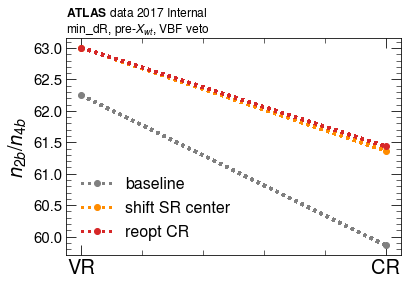

In [71]:
for k2,k4,c,l in zip([kr_2b_old,kr_2b,kr_2b_new],[kr_4b_old,kr_4b,kr_4b_new],
                   ['grey','darkorange','C3'],['baseline','shift SR center','reopt CR']):
    
    r = np.array(k2[1:]) / np.array(k4)
    
    plt.plot(r,color=c, marker='o',markersize=6,
             linestyle=ls,label=l)


    n = np.abs(r[0]-r[1])  
    print(n)
    
plt.xticks(range(2),['VR','CR'],fontsize=20)
plt.ylabel('$n_{2b} / n_{4b}$',fontsize=20)
plt.legend(fontsize=16)

ax=plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)
plt.savefig(f'{figDir}/n2b_by_n4b_extrap_delta_{delta}_eps1_{epsilon1}_eps2_{epsilon2}.pdf',bbox_inches='tight')
plt.show()

2.389574562865498
1.639812547098714
1.5687518535697862


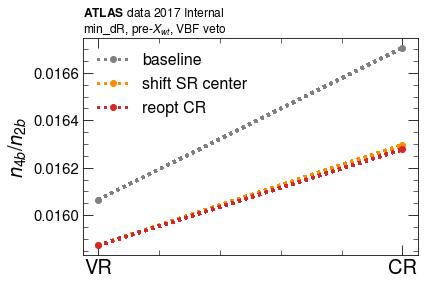

In [72]:
for k2,k4,c,l in zip([kr_2b_old,kr_2b,kr_2b_new],[kr_4b_old,kr_4b,kr_4b_new],
                   ['grey','darkorange','C3'],['baseline','shift SR center','reopt CR']):
    
    r = np.array(k2[1:]) / np.array(k4)
    
    plt.plot(1/r,color=c, marker='o',markersize=6,
             linestyle=ls,label=l)


    n = np.abs(r[0]-r[1])  
    print(n)
    
plt.xticks(range(2),['VR','CR'],fontsize=20)
plt.ylabel('$n_{4b} / n_{2b}$',fontsize=20)

plt.legend(fontsize=16)
ax=plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)

plt.savefig(f'{figDir}/n4b_by_n2b_extrap_delta_{delta}_eps1_{epsilon1}_eps2_{epsilon2}.pdf',bbox_inches='tight')

plt.show()

**Let's *draw* these new CR / VRs**

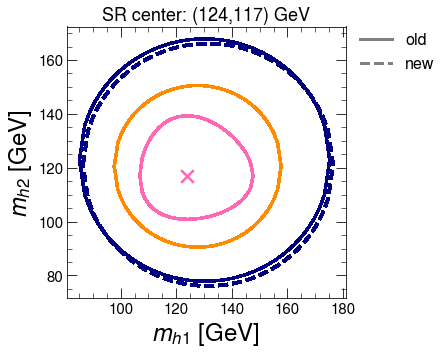

In [73]:
plt.figure(figsize=(5,5))
    
# Draw SR
x,y = draw_SR()
plt.scatter([x1],[y1],160,marker='x',color='hotpink') 
plt.plot(x,y,color='hotpink')

# # Draw VRs
x,y = draw_VR()
plt.plot(x,y,color='darkorange')
# x,y = draw_VR(delta1=delta1,delta2=delta2)
# plt.plot(x,y,color='darkorange',ls='--')

# # Draw CRs
x,y = draw_CR()
plt.plot(x,y,color='navy')
x,y = draw_CR(eps1=epsilon1,eps2=epsilon2)
plt.plot(x,y,color='navy',ls='--')

plt.xlabel('$m_{h1}$ [GeV]',fontsize=24)
plt.ylabel('$m_{h2}$ [GeV]',fontsize=24)

plt.title(f'SR center: ({x1},{y1}) GeV')

plt.plot([],[],color='grey',ls='-',label='old')

plt.plot([],[],color='grey',ls='--',label='new')
plt.legend(bbox_to_anchor=(1,1.03),fontsize=16)

plt.savefig(f'{figDir}/newRegionProposals_delta_{delta}_eps1_{epsilon1}_eps2_{epsilon2}.pdf',bbox_inches='tight')
plt.show()

Putting the old regions on the same plot made is *too* busy.

In [74]:
'''
Draw the old analysis regions
'''
# plt.scatter([x1],[y1],160,marker='x',color='hotpink') 
# for f in [draw_SR,draw_VR,draw_CR]:
#     x,y = f(x0,y0)
#     plt.plot(x,y,color='grey')

'\nDraw the old analysis regions\n'